In [1]:
# #!/usr/bin/env python
# # coding: utf-8

# # In[1]:

# import argparse
# # Params
# parser = argparse.ArgumentParser(description='BO')
# # parser.add_argument('--model', default='DnCNN_wBeta_woMean_BF', type=str, help='choose a type of model')
# # parser.add_argument('--batch_size', default=128, type=int, help='batch size')
# # parser.add_argument('--train_data', default='Train400', type=str, help='path of train data')
# # parser.add_argument('--sigma', default=[0,80], help='noise level')
# # parser.add_argument('--epoch', default=180, type=int, help='number of train epoches')
# # parser.add_argument('--lr', default=1e-3, type=float, help='initial learning rate for Adam')
# # parser.add_argument('--gpu_idx', default=0, type=float, help='gpu idx')

# parser.add_argument('--itag', default=0, type=int, help='itag')
# parser.add_argument('--n_start', default=20, type=int, help='number of start points')


# #
# args = parser.parse_args()

# itag = args.itag
# n_start = args.n_start

itag = 0
n_start = 20

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import HuberRegressor, LinearRegression
from Tools import *


# In[2]:

from GPyOpt.methods import BayesianOptimization
import os
import time as tm


# In[3]:

import joblib
# joblib.dump(model, "model_artificial_truth.m")
# model = joblib.load("model_artificial_truth.m")


# In[4]:

from openpyxl import load_workbook

In [3]:
np.random.seed(100) # 1,10,100,200,400

## Design the call function (basic)

Aim: given a batch of x=content, fill the properties by graph models.

In [4]:
import sys
for path in ['../','../../','../../../','../../../../']:
    sys.path.append(path+"CNT_Code/V1.05.22")
    
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from RegressionTools import *
from GraphTools import *
from GeneralTools import *
# from GraphModel import *
from GraphModel_cnt import *
from CNT_Dataset import *
from ModelSelection import *

In [5]:
data_org = pd.read_excel('data_all_back_A.xlsx') # 2020.06.06 use data back -- no log(*)
graph_array = data_load('graph_array_368.dat')

In [6]:
gm = data_load('gm.dat')

In [7]:
idx = ['P3HT vol (µL)','D1 vol (µL)', 'D2 vol (µL)', 'D6 vol (µL)', 'D8 vol (µL)',]
# idy = 'Conductivity (modified predict)'
idy = 'Y'; targy = 'Cond'
idz = 'R'; targz = 'Abs'

id_targ = idy; this_targ = targy
# id_targ = idz; this_targ = targz

In [8]:
gm_array = data_load('gm_array.dat')

In [9]:
def _call(x):
    res_array = []
    for i in range(len(x)):
        gm = np.random.choice(gm_array)
        data_x = pd.DataFrame(x[i:i+1],columns=idx)
        for s in ['A','R','S','T','Y']: data_x[s] = np.nan;
        res = gm.predict(data=data_x,n_predict=1,ensemble=False,random=True)
        res['predicted by graph'] = nx2str(gm.G)
        res_array.append(res)
    return pd.concat(res_array)

In [10]:
# test
x = [[6.683916151,86.37989419,3.238535166,3.376116023,0.420909719],
     [6.683916151,86.37989419,3.238535166,3.376116023,0.420909719],
    [6.683916151,86.37989419,3.238535166,3.376116023,0.420909719],
    [6.683916151,86.37989419,3.238535166,3.376116023,0.420909719],
    [6.683916151,86.37989419,3.238535166,3.376116023,0.420909719],
    [6.683916151,86.37989419,3.238535166,3.376116023,0.420909719],]
res = _call(x)
res
pd.DataFrame(res)

,P3HT vol (µL),D1 vol (µL),D2 vol (µL),D6 vol (µL),D8 vol (µL),A,R,S,T,Y,call,predicted by graph
0,6.683916,86.379894,3.238535,3.376116,0.42091,0.608759,0.008930,3.152430,NaN,6.165426,1,"C->R, CR->S, C->A, CARS->Y"
0,6.683916,86.379894,3.238535,3.376116,0.42091,NaN,-0.003954,NaN,NaN,6.164449,1,"C->R, CR->Y"
0,6.683916,86.379894,3.238535,3.376116,0.42091,0.997164,-0.008326,3.324094,NaN,5.952397,1,"C->R, CR->S, C->A, CAS->Y"
0,6.683916,86.379894,3.238535,3.376116,0.42091,0.833100,-0.003191,3.313574,NaN,5.984653,1,"C->R, CR->S, C->A, CAS->Y"
0,6.683916,86.379894,3.238535,3.376116,0.42091,0.638152,-0.008511,2.881367,6.77486,6.461868,1,"C->S, C->R, C->A, CARS->T, ST->Y"
0,6.683916,86.379894,3.238535,3.376116,0.42091,0.810869,-0.006681,3.508773,NaN,5.757977,1,"C->R, CR->S, C->A, ARS->Y"


## ExperimentGroundexperiment

In [11]:
# use the "_call" function to do artifical experiments
class ExperimentGroundexperiment():
    
    def __init__(self,target=None,tag = 'demo',filename=None):
        
        self.columns = idx + ['A','R','S','T','Y'] + ['call','predicted by graph','run','target']
        self.target = target
        
        
        self.data = pd.DataFrame(columns=self.columns)
        self.data_history = []
        self.run = 0
        
        self.filename = 'Artificial_BO_%s_history_%s.xlsx'%(tag,self.target)
        
    def Call(self,x): # x is a numpy instance
        
        data_x = pd.DataFrame(x,columns=idx)
        res = _call(data_x) # res is a pandas
        self.update_data(x,res) # update the pandas data history
        self.save() # save the new call
        #print(self.data)

        if self.target is targy:
            return res[idy].values
        if self.target is targz:
            return res[idz].values
        
    def update_data(self,x,res): # if res is a pandas
        
        res['run'] = self.run
        res['target'] = self.target
        self.run += 1
        self.data = self.data.append(res)
        
#     def update_data_dict(self,x,res): # if res is a dict
        
#         data_x = pd.DataFrame(x,columns=idx)
#         res.update({'run':self.run,'target':self.target})
#         data_res = pd.DataFrame(res)
#         #data_targ = pd.DataFrame({'run':self.run,'target':self.target})
#         data = pd.concat([data_x,data_res],axis=1, join='inner')
#         self.run += 1
        
#         self.data = self.data.append(data)
        
    def save(self): # save the call history to xlsx
        
        self.data_history.append(self.data.copy())
        sheet_name='%d'%(self.run)
        
        from openpyxl import load_workbook
        
        with pd.ExcelWriter(self.filename) as writer:
            for i,data in enumerate(self.data_history):
                data.to_excel(writer,sheet_name='%d'%(i))

## Test call

In [12]:
experiment = ExperimentGroundexperiment(target=this_targ)

x = [[18.338832,0.067660,25.274938,48.684947,7.652860],
     [18.338832,0.067660,25.274938,48.684947,1.652860]]

experiment.Call(x)
experiment.Call(x)
experiment.run
experiment.data

,P3HT vol (µL),D1 vol (µL),D2 vol (µL),D6 vol (µL),D8 vol (µL),A,R,S,T,Y,call,predicted by graph,run,target
0,18.338832,0.06766,25.274938,48.684947,7.65286,0.281065,-0.091446,7.058657,NaN,2.978344,1,"C->R, CR->S, C->A, CARS->Y",0,Cond
1,18.338832,0.06766,25.274938,48.684947,1.65286,0.348210,-0.080000,NaN,NaN,2.459746,1,"C->R, R->A, CAR->Y",0,Cond
0,18.338832,0.06766,25.274938,48.684947,7.65286,NaN,NaN,NaN,NaN,2.776292,1,C->Y,1,Cond
1,18.338832,0.06766,25.274938,48.684947,1.65286,0.315044,-0.083841,6.651869,NaN,3.374426,1,"C->R, CR->S, C->A, ARS->Y",1,Cond


## BO

### Configurations for artificial experiments

In [13]:
# itag = 0
# n_start = 20
experiment = ExperimentGroundexperiment(target=this_targ,
                                        tag="20200701demo_%dT%d"%(n_start,itag))

### Generater initial dataset

There are many sample strategies. We use the `random_sample_content`

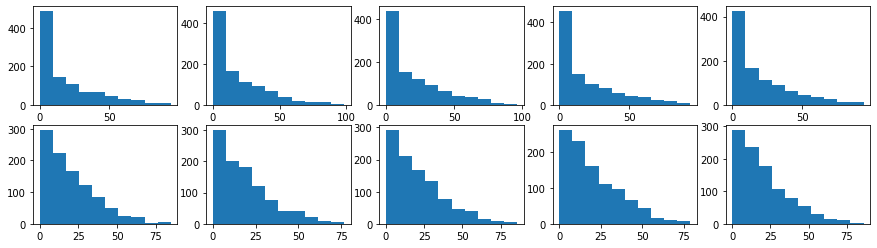

In [14]:
# the simplest strategy -- prior on one-component
def random_sample_content_del(n_start=100):
    # x = np.random.rand(n_start,5)
    x = np.random.randn(n_start,5)**2
    x = 100*x/np.sum(x,axis=1).reshape(-1,1)
    return x
# here we use this one: uniformly sample from simplex
def random_sample_content(n_start=100):
    x = 100 * np.hstack([np.zeros([n_start,1]),np.random.rand(n_start,4),np.ones([n_start,1])])
    x.sort(axis=1)
    x = x[:,1:] - x[:,:-1]
    # x.round(1)
    return x

plt.figure(figsize=[15,4])
xs1 = random_sample_content_del(1000)
xs2 = random_sample_content(1000)
for i in range(5):
    plt.subplot(2,5,i+1);plt.hist(xs1[:,i]);
    plt.subplot(2,5,i+1+5);plt.hist(xs2[:,i]);

In [15]:
x = random_sample_content(n_start)
# experiment = ExperimentGroundexperiment(...)
y = experiment.Call(x).reshape(-1,1)
experiment.data # pandas

,P3HT vol (µL),D1 vol (µL),D2 vol (µL),D6 vol (µL),D8 vol (µL),A,R,S,T,Y,call,predicted by graph,run,target
0,23.961991,7.297423,50.270115,1.086712,17.383758,NaN,NaN,NaN,NaN,3.067572,1,C->Y,0,Cond
1,8.139887,62.855355,14.965426,7.981983,6.057348,1.041576,-0.012298,4.264575,NaN,5.122820,1,"C->R, CR->S, C->A, CAS->Y",0,Cond
2,26.295412,17.474609,0.200725,44.180441,11.848813,0.388002,-0.152395,NaN,NaN,3.337055,1,"C->R, R->A, CAR->Y",0,Cond
3,29.999051,34.734203,9.477170,3.856221,21.933355,NaN,-0.023452,NaN,NaN,4.509288,1,"C->R, CR->Y",0,Cond
4,11.216598,40.770940,2.902874,31.414622,13.694967,0.984767,-0.074401,5.190699,NaN,4.457624,1,"C->R, CR->S, C->A, ARS->Y",0,Cond
5,7.718342,6.914248,10.012200,74.440721,0.914489,0.462651,-0.151783,NaN,NaN,2.824626,1,"C->R, C->A, CAR->Y",0,Cond
6,13.108117,7.653471,6.966866,12.083646,60.187901,0.465174,0.009269,NaN,NaN,4.133096,1,"C->R, CR->A, CAR->Y",0,Cond
7,58.195220,0.427510,7.271921,29.730696,4.374653,NaN,NaN,NaN,NaN,2.711880,1,C->Y,0,Cond
8,30.009743,8.323395,5.826083,11.940642,43.900138,0.333428,0.005494,5.622815,NaN,4.393996,1,"C->R, CR->S, C->A, CAS->Y",0,Cond
9,13.864402,8.460719,39.374018,10.364223,27.936638,0.249082,0.013600,6.266139,NaN,3.782967,1,"C->R, CR->S, C->A, CAS->Y",0,Cond


In [16]:
# experiment.Call(x)

array([3.13293209, 5.19536969, 3.73503406, 3.89473343, 4.81354495,
       3.4126176 , 4.64136515, 2.84041043, 3.1087652 , 2.74292417,
       3.54000465, 4.55027038, 4.57982488, 2.85846786, 3.47534636,
       3.85407172, 4.11522429, 3.37871002, 3.31585485, 3.59036195])

### Configuration for BO

In [17]:
bds = [ {'name':idx[0],'type':'continuous','domain':(0.05,100)},
        {'name':idx[1],'type':'continuous','domain':(0.05,100)},
        {'name':idx[2],'type':'continuous','domain':(0.05,100)},
        {'name':idx[3],'type':'continuous','domain':(0.05,100)},
        {'name':idx[4],'type':'continuous','domain':(0.05,100)}
        ]
        
constraints = [
    {
        'name': 'constr_1',
        'constraint': '(x[:,0] + x[:,1] + x[:,2] + x[:,3] + x[:,4]) - 100 - 0.1'
    },
    {
        'name': 'constr_2',
        'constraint': '100 - (x[:,0] + x[:,1] + x[:,2] + x[:,3] + x[:,4]) - 0.1'
    }
    ]    
    

        
batch_size = 9
num_cores = 4

### Run BO

`experiment.data` contains all X and Y information.

In [18]:
# func = experiment.Call
func = None

print(tm.ctime())
for Run in range(20):
    
    X = experiment.data[idx].values
    Y = experiment.data[[id_targ]].values.reshape([-1,1])

    batch_optimizer = BayesianOptimization(f= func,
                                           domain = bds,
                                           model_type='GP',
                                           #initial_design_numdata=20,
                                           initial_design_numdata=0,
                                           constraints = constraints,
                                           acquisition_type ='EI',
                                           acquisition_jitter = 0.5,
                                           X=X,
                                           Y= -1*Y,
                                           exact_feval = False,  
                                           evaluator_type = 'local_penalization',
                                           batch_size = batch_size,
                                           num_cores = num_cores,
                                           maximize= False)

    batch_x_next = batch_optimizer.suggest_next_locations()

    experiment.Call(batch_x_next)

    df = pd.DataFrame(batch_x_next)
    df.columns = idx
    print(tm.ctime())

Wed Jul  1 16:46:03 2020
Wed Jul  1 16:49:32 2020
Wed Jul  1 16:52:58 2020
Wed Jul  1 16:56:18 2020


KeyboardInterrupt: 

In [21]:
experiment.data

,P3HT vol (µL),D1 vol (µL),D2 vol (µL),D6 vol (µL),D8 vol (µL),A,R,S,T,Y,call,predicted by graph,run,target
0,23.961991,7.297423,50.270115,1.086712,17.383758,NaN,NaN,NaN,NaN,3.067572,1,C->Y,0,Cond
1,8.139887,62.855355,14.965426,7.981983,6.057348,1.041576,-0.012298,4.264575,NaN,5.122820,1,"C->R, CR->S, C->A, CAS->Y",0,Cond
2,26.295412,17.474609,0.200725,44.180441,11.848813,0.388002,-0.152395,NaN,NaN,3.337055,1,"C->R, R->A, CAR->Y",0,Cond
3,29.999051,34.734203,9.477170,3.856221,21.933355,NaN,-0.023452,NaN,NaN,4.509288,1,"C->R, CR->Y",0,Cond
4,11.216598,40.770940,2.902874,31.414622,13.694967,0.984767,-0.074401,5.190699,NaN,4.457624,1,"C->R, CR->S, C->A, ARS->Y",0,Cond
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0.421738,79.519561,2.665259,2.591702,14.879075,0.934270,0.011440,NaN,NaN,6.175925,1,"C->R, R->A, CAR->Y",4,Cond
5,4.055319,81.963314,3.192090,6.656299,4.161353,1.077773,0.001827,NaN,NaN,5.883440,1,"C->R, CR->A, CAR->Y",4,Cond
6,1.499172,51.993465,1.455669,3.028848,41.930187,1.064328,-0.001684,4.146491,NaN,5.414531,1,"C->R, CR->S, C->A, CARS->Y",4,Cond
7,0.493505,90.270643,3.320584,4.061958,1.947525,NaN,NaN,NaN,NaN,6.381855,1,C->Y,4,Cond


In [ ]:
# batch_optimizer.run_optimization()
# vars(batch_optimizer.model.model).keys()
# batch_optimizer.model
# experiment.data